<a href="https://colab.research.google.com/github/Vicky-0222/ML/blob/master/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обучение без учителя

## 1. Предобработка

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Загрузка набора данных
df = pd.read_csv('/content/juice.csv')

In [13]:
df = df.drop('Id', axis=1)

### Преобразование категориальных переменных

In [14]:
# Создаем копию данных
category_columns: list[str] = df.select_dtypes(include=['object']).columns # собираем колонки помеченные как objects

# Применяем One-Hot Encoding
df = pd.get_dummies(df, columns=category_columns, drop_first=True)
df.Purchase_MM = df.Purchase_MM.astype(int)
df.Store7_Yes = df.Store7_Yes.astype(int)

### Преобразование непрерывных переменных

In [15]:
from sklearn.preprocessing import MinMaxScaler
# Выбираем числовые признаки
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Инициализируем scaler
scaler = MinMaxScaler()

# Применяем нормализацию
df[numeric_features] = scaler.fit_transform(df[numeric_features])

In [16]:
df

,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,PctDiscMM,PctDiscCH,ListPriceDiff,STORE,Purchase_MM,Store7_Yes
0,0.196078,0.0,0.150,0.500000,0.00,0.000,0.0,0.0,0.500021,0.727273,0.514286,0.694656,0.000000,0.000000,0.545455,0.25,0.0,0.0
1,0.235294,0.0,0.150,0.500000,0.00,0.375,0.0,1.0,0.600027,0.454545,0.514286,0.465649,0.375001,0.000000,0.545455,0.25,0.0,0.0
2,0.352941,0.0,0.425,0.666667,0.34,0.000,0.0,0.0,0.680033,0.818182,0.428571,0.816794,0.000000,0.361703,0.522727,0.25,0.0,0.0
3,0.000000,0.0,0.000,0.000000,0.00,0.000,0.0,0.0,0.400015,0.454545,0.428571,0.511450,0.000000,0.000000,0.000000,0.25,1.0,0.0
4,0.019608,1.0,0.000,0.000000,0.00,0.000,0.0,0.0,0.956585,0.454545,0.428571,0.511450,0.000000,0.000000,0.000000,0.00,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,0.490196,1.0,0.425,0.666667,0.20,0.000,0.0,0.0,0.587849,0.818182,0.528571,0.763359,0.000000,0.212764,0.522727,0.00,0.0,1.0
1066,0.568627,1.0,0.425,0.816667,0.00,0.000,0.0,0.0,0.670290,0.900000,0.671429,0.755725,0.000000,0.000000,0.727273,0.00,0.0,1.0
1067,0.588235,1.0,0.425,0.816667,0.00,0.000,0.0,0.0,0.736242,0.900000,0.671429,0.755725,0.000000,0.000000,0.727273,0.00,1.0,1.0
1068,0.666667,1.0,0.425,0.733333,0.00,0.300,0.0,0.0,0.588992,0.636364,0.671429,0.534351,0.280282,0.000000,0.613636,0.00,0.0,1.0


In [17]:
! pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.4 MB/s eta 0:00:00


### K-means

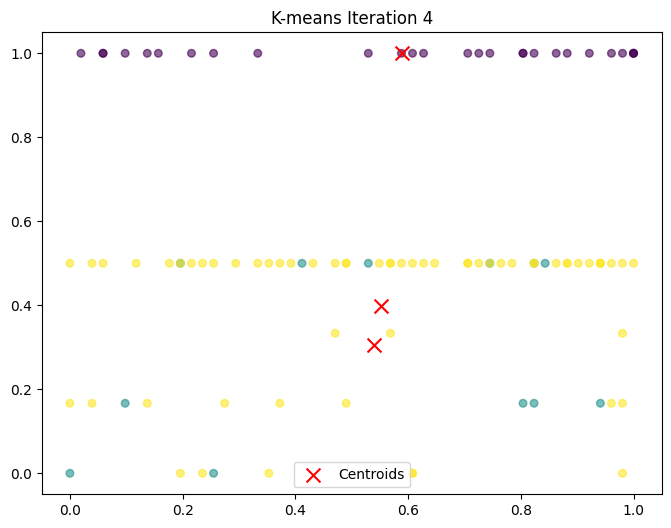

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

def interactive_kmeans_visualization(X, max_clusters=10, max_iterations=50):

    # преобразуем X в numpy array
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_kmeans_iteration(X, centroids, labels=None, step=0):
        clear_output(wait=True)
        plt.figure(figsize=(8, 6))
        if labels is not None:
            plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6)
        else:
            plt.scatter(X[:, 0], X[:, 1], s=30, alpha=0.6)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
        plt.title(f'K-means Iteration {step}')
        plt.legend()
        plt.show()

    def k_means_interactive(X, k, max_iters):
        np.random.seed(42)
        centroids = X[np.random.choice(X.shape[0], k, replace=False)]
        for step in range(max_iters):
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)
            plot_kmeans_iteration(X, centroids, labels, step)
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
            if np.all(centroids == new_centroids):
                break
            centroids = new_centroids

    def run_kmeans(k, max_iters):
        k_means_interactive(X, k, max_iters)

    k_slider = widgets.IntSlider(value=3, min=2, max=max_clusters, step=1, description='Clusters (k):')
    iter_slider = widgets.IntSlider(value=10, min=1, max=max_iterations, step=1, description='Max Iterations:')

    interactive_plot = widgets.interactive(run_kmeans, k=k_slider, max_iters=iter_slider)
    display(interactive_plot)

# Берем датасет и визуализируем K-means
interactive_kmeans_visualization(df[:100])

### K-means через реализацию sklearn

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Определяем количество кластеров k
k = 5  # Вы можете изменить это значение в соответствии с вашими данными

# Создаем и обучаем модель KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(df)
centroids = kmeans.cluster_centers_

# Добавляем метки кластеров в исходный DataFrame
df_k_means = df.copy()
df_k_means['Cluster'] = labels

# Вывод статистики по кластерам для каждого признака
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_k_means.groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if k > 1:
    silhouette_avg = silhouette_score(df, labels)
    print(f"\nКоэффициент силуэта для k={k}: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен для k=1")

Статистика по кластерам:

Статистика для признака 'WeekofPurchase':
             mean       std       min       max
Cluster                                        
0        0.684734  0.266929  0.235294  0.980392
1        0.549076  0.291354  0.000000  1.000000
2        0.826731  0.093070  0.705882  0.980392
3        0.467307  0.294465  0.000000  1.000000
4        0.384314  0.290505  0.000000  1.000000

Статистика для признака 'StoreID':
             mean       std  min  max
Cluster                              
0        0.190476  0.231917  0.0  1.0
1        0.272158  0.190005  0.0  0.5
2        1.000000  0.000000  1.0  1.0
3        1.000000  0.000000  1.0  1.0
4        0.246809  0.142335  0.0  0.5

Статистика для признака 'PriceCH':
             mean       std    min    max
Cluster                                  
0        0.524107  0.244552  0.150  1.000
1        0.504913  0.271351  0.000  1.000
2        0.464796  0.107084  0.425  0.750
3        0.345518  0.208104  0.000  0.925
4     

PriceCH и PriceMM для всех кластеров почти одинаковый так как цена в магазинах не сильно отличается.

Store7: Наличие в магазине можно увидеть у 2 и 3 кластера

Purchase_MM: в кластере 4 только MM (оплата наличными(?)), кластер 1 не продается или оплачивается другим способом, в остальных случаях (0, 2, 3) оплата и наличными и безналичными.


### DBSCAN

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import display, clear_output
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

def interactive_dbscan_visualization(X):
    if isinstance(X, pd.DataFrame):
        X = X.values

    def plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric):
        clear_output(wait=True)
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.figure(figsize=(8, 6))
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Черный цвет для шума
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
        plt.show()

    def run_dbscan(eps, min_samples, metric):
        # Обучение DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
        db.fit(X)
        labels = db.labels_
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        plot_dbscan(X, labels, core_samples_mask, eps, min_samples, metric)

    # Виджеты для настройки параметров
    eps_slider = widgets.FloatSlider(value=1, min=0.1, max=1.0, step=0.05, description='eps:')
    min_samples_slider = widgets.IntSlider(value=10, min=1, max=20, step=1, description='min_samples:')
    metric_dropdown = widgets.Dropdown(options=['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
                                       value='euclidean', description='metric:')

    ui = widgets.VBox([eps_slider, min_samples_slider, metric_dropdown])
    out = widgets.interactive_output(run_dbscan, {'eps': eps_slider, 'min_samples': min_samples_slider, 'metric': metric_dropdown})
    display(ui, out)

# Пример использования
interactive_dbscan_visualization(df[:120])

Output()

### DBSCAN через sklearn

Количество кластеров: 8
Статистика по кластерам:

Статистика для признака 'WeekofPurchase':
             mean       std       min       max  count
Cluster                                               
0        0.500963  0.298728  0.000000  1.000000    550
1        0.633209  0.277053  0.000000  0.960784    126
2        0.123366  0.009104  0.117647  0.137255     24
3        0.551571  0.240689  0.019608  1.000000    146
4        0.776887  0.041383  0.725490  0.843137     66
5        0.921569  0.000000  0.921569  0.921569     18
6        0.980392  0.000000  0.980392  0.980392     10
7        0.428035  0.244435  0.019608  1.000000     47

Статистика для признака 'StoreID':
             mean       std  min  max  count
Cluster                                     
0        0.265758  0.171098  0.0  0.5    550
1        0.117725  0.111689  0.0  0.5    126
2        1.000000  0.000000  1.0  1.0     24
3        1.000000  0.000000  1.0  1.0    146
4        1.000000  0.000000  1.0  1.0     66
5      

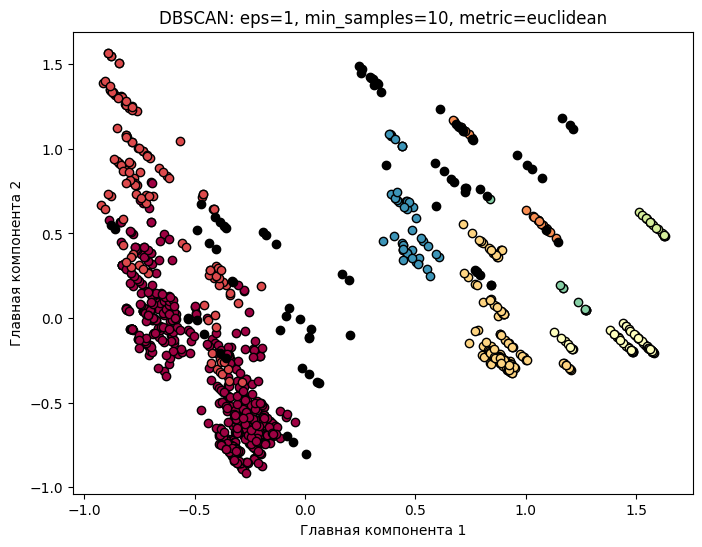

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Параметры DBSCAN
eps = 1
min_samples = 10
metric = 'euclidean'

# Обучение модели DBSCAN
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
labels = db.fit_predict(df)

# Добавляем метки кластеров в DataFrame
df_dbscan = df.copy()
df_dbscan['Cluster'] = labels

# Количество кластеров (исключая шум)
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Количество кластеров: {n_clusters_}")

# Вывод статистики по кластерам
print("Статистика по кластерам:")
for column in df.columns:
    print(f"\nСтатистика для признака '{column}':")
    cluster_stats = df_dbscan[df_dbscan['Cluster'] != -1].groupby('Cluster')[column].agg(['mean', 'std', 'min', 'max', 'count'])
    print(cluster_stats)

# Вычисление коэффициента силуэта
if n_clusters_ > 1:
    silhouette_avg = silhouette_score(df[df_dbscan['Cluster'] != -1], labels[df_dbscan['Cluster'] != -1])
    print(f"\nКоэффициент силуэта для DBSCAN: {silhouette_avg:.4f}")
else:
    print("\nКоэффициент силуэта не определен, так как найден один кластер или данные являются шумом.")


# Визуализация результатов (с использованием PCA для снижения размерности)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
df_pca['Cluster'] = labels

plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    if k == -1:
        # Черный цвет для шума
        col = [0, 0, 0, 1]
    plt.plot(df_pca.loc[class_member_mask, 'PC1'],
             df_pca.loc[class_member_mask, 'PC2'],
             'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'DBSCAN: eps={eps}, min_samples={min_samples}, metric={metric}')
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.show()

PriceCH и PriceMM также одинаковы для всех кластеров

SpecialCH: для кластеров 2, 4, 5 для безналичного расчета походу были спец предложения или особые виды сока

SpecialMM: для кластеров 1, 6 для наличного расчет также были спец предложения или особые виды сока

Для остальных кластеров таких предложений нет

Наличие в магазине только для кластеров 2, 3, 4, 6, 7



#### Метрики качества кластеризации

##### K-means

In [22]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
# Кластеризация K-means
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
labels_kmeans = kmeans.fit_predict(df)

# Индекс Калински-Харабаза
ch_score_kmeans = calinski_harabasz_score(df, labels_kmeans)
print(f"Индекс Калински-Харабаза для K-means: {ch_score_kmeans:.4f}")

# Индекс Дэвиса-Болдина
db_score_kmeans = davies_bouldin_score(df, labels_kmeans)
print(f"Индекс Дэвиса-Болдина для K-means: {db_score_kmeans:.4f}")

# Коэффициент силуэта
sh_score_kmeans = silhouette_score(df, labels_kmeans)
print(f"Коэффициент силуэта для K-means: {sh_score_kmeans:.4f}")

Индекс Калински-Харабаза для K-means: 359.5999
Индекс Дэвиса-Болдина для K-means: 1.5150
Коэффициент силуэта для K-means: 0.2618


разделение кластеров хороший, но они немножко перекрываются

##### DBSCAN

In [23]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

eps = 0.5
min_samples = 5

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(df)

# Исключаем шумовые точки (метки -1)
mask = labels_dbscan != -1
df_scaled_dbscan = df[mask]
labels_dbscan_filtered = labels_dbscan[mask]

# Проверяем, есть ли достаточное количество кластеров для расчета метрик
if len(set(labels_dbscan_filtered)) > 1:
    # Индекс Калински-Харабаза
    ch_score_dbscan = calinski_harabasz_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Калински-Харабаза для DBSCAN: {ch_score_dbscan:.4f}")

    # Индекс Дэвиса-Болдина
    db_score_dbscan = davies_bouldin_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Индекс Дэвиса-Болдина для DBSCAN: {db_score_dbscan:.4f}")

    # Коэффициент силуэта
    sh_score_dbscan = silhouette_score(df_scaled_dbscan, labels_dbscan_filtered)
    print(f"Коэффициент силуэта для DBSCAN: {sh_score_dbscan:.4f}")
else:
    print("Недостаточно кластеров для вычисления метрик для DBSCAN.")

Индекс Калински-Харабаза для DBSCAN: 226.3275
Индекс Дэвиса-Болдина для DBSCAN: 0.6507
Коэффициент силуэта для DBSCAN: 0.4261


здесь ситуация чуть-чуть лучше, хотя индекс калински уменьшился.

##### Визуальный пример

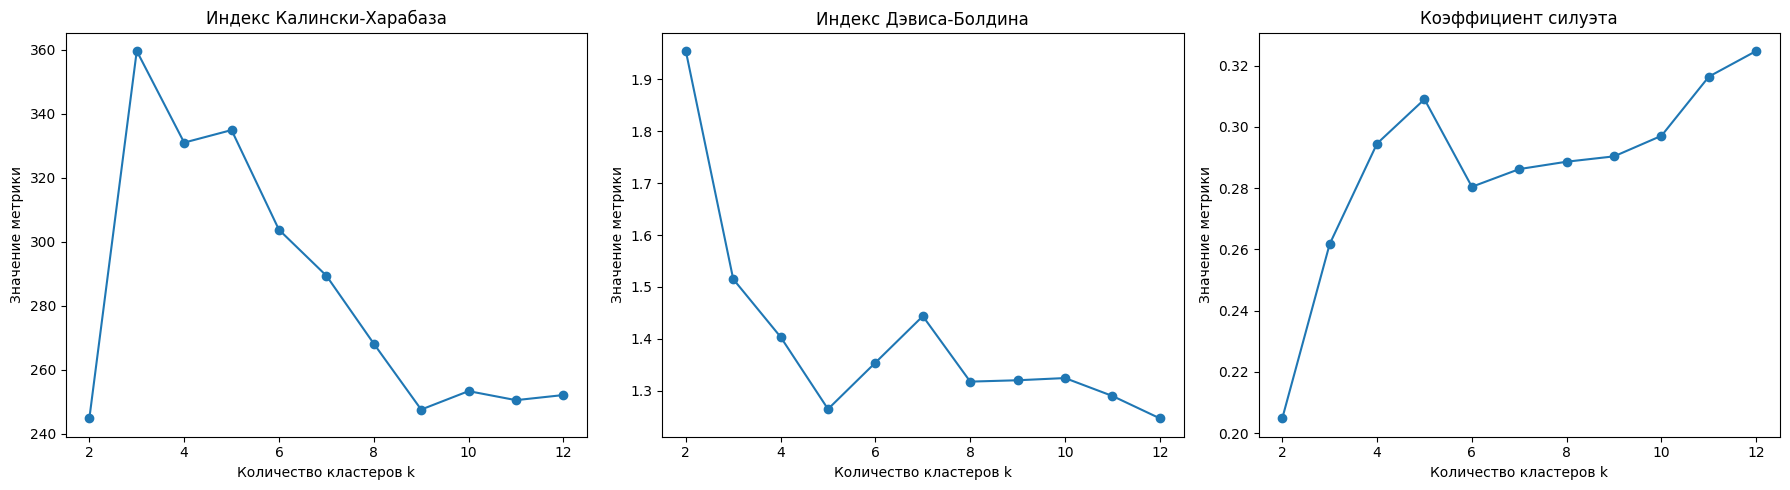

In [24]:
# Диапазон значений k
k_range = range(2, 13)

# Списки для хранения метрик
ch_scores = []
db_scores = []
silhouette_scores = []

for k in k_range:
    # Создаем и обучаем модель KMeans
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df)

    # Вычисляем метрики
    ch_score = calinski_harabasz_score(df, labels)
    db_score = davies_bouldin_score(df, labels)
    silhouette_avg = silhouette_score(df, labels)

    # Сохраняем метрики
    ch_scores.append(ch_score)
    db_scores.append(db_score)
    silhouette_scores.append(silhouette_avg)

# Построение графиков
plt.figure(figsize=(18, 5))

# График Индекса Калински-Харабаза
plt.subplot(1, 3, 1)
plt.plot(k_range, ch_scores, marker='o')
plt.title('Индекс Калински-Харабаза')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Индекса Дэвиса-Болдина
plt.subplot(1, 3, 2)
plt.plot(k_range, db_scores, marker='o')
plt.title('Индекс Дэвиса-Болдина')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

# График Коэффициента силуэта
plt.subplot(1, 3, 3)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров k')
plt.ylabel('Значение метрики')

plt.tight_layout()
plt.show()